<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR_Pamap2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [ ]:
dataset_path = 'Pamap2'

In [ ]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','running',
     'cycling','NordicWalking', 'ascendingStairs', 'descendingStairs',
    'vacuumCleaning','ironing','houseCleaning','ropeJumping']

In [ ]:
classes_to_rename = {
     1:'lying',
     2:'sitting',
     3:'standing',
     4:'walking',
     5:'running',
     6: 'cycling',
     7:'NordicWalking',
     9: 'watchingTV',
     10: 'computerWork',
     11: 'carDriving',
    12: 'ascendingStairs',
    13: 'descendingStairs',
    16:'vacuumCleaning',
    17:'ironing',
    18:'foldingLaundry',
    19:'houseCleaning',
    20:'playingSoccer',
    24:'ropeJumping',
    0:'other'
}

In [ ]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = False
aggregate_falls = True
use_speed=False
use_total_speed=False
use_timestamp=False
use_squared_components=False
use_squared_speed=False
use_sign_speed=False
use_position=False

In [ ]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [ ]:
save_features = False

In [ ]:
batchsize = 512

In [ ]:
from os import mkdir
mkdir(folder_name)

In [ ]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# Caricamento dati

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
def load(dataset_path,id):
  columns=[]
  for i in range(54):
    columns.append(str(i))
  columns
  df = pd.read_csv(dataset_path, names=columns, delim_whitespace=True)
  df=df[['0','1','4','5','6']]
  df = df.rename({'0': 'timestamp', '1': 'activity', '4': 'x_axis',
                 '5': 'y_axis', '6': 'z_axis'}, axis=1) 
  df.insert(0, "user_id", id, True)
  return df

In [ ]:
#dataset_path = '/content/Dataset/subject10'
dataset_path = '/content/gdrive/MyDrive/Protocol/subject10'
path = []
num_user = 9

for i in range(num_user):
  if i != 0:
    path.append(dataset_path + str(i) + '.dat')

In [ ]:
#load data subject by subject
column_names = ['user_id','timestamp', 'activity', 'x_axis','y_axis', 'z_axis']
df = pd.DataFrame(columns=column_names)
i=1
for x in path:
  #pd.concat(df, load(x,i))
  df = pd.concat([df, load(x,i)], ignore_index=True)
  i+=1


In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

user_id      0
timestamp    0
activity     0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [ ]:
df.head(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,1,8.38,0,2.37223,8.60074,3.51048
1,1,8.39,0,2.18837,8.56560,3.66179
2,1,8.40,0,2.37357,8.60107,3.54898
3,1,8.41,0,2.07473,8.52853,3.66021
4,1,8.42,0,2.22936,8.83122,3.70000
5,1,8.43,0,2.29959,8.82929,3.54710
6,1,8.44,0,2.33738,8.82900,3.54767
7,1,8.45,0,2.37142,9.05500,3.39347
8,1,8.46,0,2.33951,9.13251,3.54668
9,1,8.47,0,2.25966,9.09415,3.43015


In [ ]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
549121,2,1732.68,0,-10.03050,4.24390,1.83838
1051012,3,2281.59,4,-11.18850,4.38948,4.36071
1512446,5,1071.90,17,-3.87777,2.86171,9.63269
342477,1,3433.15,0,-5.34934,8.73166,-1.33958
1275118,4,1994.39,0,-10.21540,1.39740,5.80942
834310,3,114.57,0,2.12083,9.48448,-3.92434
1617954,5,2126.98,0,-8.86970,3.28536,1.74354
809518,2,4336.65,0,-7.48196,1.08512,3.00335
2393792,7,2519.58,7,2.08149,9.05067,2.65788
858480,3,356.27,1,6.81774,1.61391,6.79509


In [ ]:
df.describe()

,timestamp,x_axis,y_axis,z_axis
count,2.850918e+06,2.850918e+06,2.850918e+06,2.850918e+06
mean,1.835518e+03,-4.968760e+00,3.574665e+00,3.178806e+00
std,1.102689e+03,5.982752e+00,6.253034e+00,3.831297e+00
min,5.640000e+00,-1.453670e+02,-1.043010e+02,-1.014520e+02
25%,8.975900e+02,-9.030820e+00,1.291692e+00,9.732612e-01
50%,1.789080e+03,-5.801160e+00,3.567155e+00,2.964410e+00
75%,2.709880e+03,-7.938312e-01,6.590905e+00,6.012110e+00
max,4.475630e+03,6.285960e+01,1.556990e+02,1.569490e+02


In [ ]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [ ]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [ ]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'ironing', 'vacuumCleaning',
       'ascendingStairs', 'descendingStairs', 'walking', 'NordicWalking',
       'cycling', 'running', 'ropeJumping'], dtype=object)

In [ ]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
609007,3,1305.13,vacuumCleaning,-1.85829,8.868480,-4.174300
1662451,7,3122.32,running,-16.43330,36.660200,-6.487720
307854,2,730.74,standing,-8.70218,4.604060,0.856395
749728,4,791.98,standing,-8.66291,3.033050,3.402450
1911169,8,3574.72,running,-23.79000,-10.394200,-0.896992
1231953,6,638.64,standing,-8.31346,3.600850,3.559720
1845137,8,2560.94,walking,-12.35800,-1.567690,-0.909478
1390153,6,3002.31,cycling,-6.28289,0.051882,7.296900
360220,2,1391.87,vacuumCleaning,-9.96740,-0.190878,2.393110
864192,4,2645.87,NordicWalking,-6.39176,-0.042613,0.906678


In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
1307597,6,1470.88,vacuumCleaning,-10.109400,-6.07838,-2.66949
1793692,8,1663.67,ascendingStairs,-9.534130,-1.79986,1.05797
284884,2,480.74,sitting,-0.932519,7.13627,6.54490
1869699,8,3036.64,cycling,-6.720940,-3.70844,10.68990
1111945,5,2735.67,NordicWalking,-0.580135,7.18315,3.62498
1298618,6,1381.06,vacuumCleaning,-6.920440,6.67353,-3.74238
1622499,7,2600.97,NordicWalking,0.397303,7.59088,3.40733
67483,1,712.93,standing,-7.530080,5.56152,2.87207
1569953,7,1780.13,ascendingStairs,-7.108840,8.24864,2.48444
801517,4,1374.80,vacuumCleaning,-7.950560,4.50311,2.94631


In [ ]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'ironing', 'vacuumCleaning',
       'ascendingStairs', 'descendingStairs', 'walking', 'NordicWalking',
       'cycling', 'running', 'ropeJumping'], dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z
0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10
2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10
3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09
4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09


In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 8


In [ ]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [ ]:
user_original_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
user_original_data[1]

,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,1,37.66,lying,2.21530,8.27915,5.58753
1,1,37.67,lying,2.29196,7.67288,5.74467
2,1,37.68,lying,2.29090,7.14240,5.82342
3,1,37.69,lying,2.21800,7.14365,5.89930
4,1,37.70,lying,2.30106,7.25857,6.09259
...,...,...,...,...,...,...
248594,1,3626.33,ropeJumping,2.51550,7.02650,5.78869
248595,1,3626.34,ropeJumping,2.50643,6.30465,5.67552
248596,1,3626.35,ropeJumping,2.54102,5.84908,5.67758
248597,1,3626.36,ropeJumping,2.65866,5.88715,5.79468


In [ ]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [ ]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

In [ ]:
user_trials[3][2]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis
50805,560306,3,769.22,standing,-1.15553,9.53225,-1.47189
50806,560307,3,769.23,standing,-1.07781,9.64582,-1.43263
50807,560308,3,769.24,standing,-1.15045,9.87438,-1.39600
50808,560309,3,769.25,standing,-1.26890,9.72249,-1.51272
50809,560310,3,769.26,standing,-1.00036,9.91081,-1.43236
...,...,...,...,...,...,...,...
71323,580824,3,974.49,standing,-2.14776,3.94450,9.19310
71324,580825,3,974.50,standing,-1.99794,3.94300,9.15686
71325,580826,3,974.51,standing,-2.00276,4.20689,8.96346
71326,580827,3,974.52,standing,-1.96042,4.09413,9.11842


In [ ]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [ ]:
trial

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis
252369,1916632,8,3800.36,ropeJumping,2.68581,-8.75650,-2.39182
252370,1916633,8,3800.37,ropeJumping,2.82895,-8.94904,-2.58146
252371,1916634,8,3800.38,ropeJumping,2.64401,-8.94657,-2.46878
252372,1916635,8,3800.39,ropeJumping,2.64481,-8.83276,-2.46915
252373,1916636,8,3800.40,ropeJumping,2.51914,-9.06220,-2.77815
...,...,...,...,...,...,...,...
261091,1925354,8,3888.37,ropeJumping,-1.56754,-9.74184,-1.75943
261092,1925355,8,3888.38,ropeJumping,-1.63804,-9.58850,-1.64554
261093,1925356,8,3888.39,ropeJumping,-1.79054,-9.58767,-1.68632
261094,1925357,8,3888.40,ropeJumping,-1.64687,-9.51497,-1.91533


In [ ]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,0,1,37.66,lying,2.21530,8.27915,5.58753
1,1,1,37.67,lying,2.29196,7.67288,5.74467
2,2,1,37.68,lying,2.29090,7.14240,5.82342
3,3,1,37.69,lying,2.21800,7.14365,5.89930
4,4,1,37.70,lying,2.30106,7.25857,6.09259
...,...,...,...,...,...,...,...
595,595,1,43.61,lying,-2.43538,7.31994,4.55892
596,596,1,43.62,lying,-2.49064,7.55286,5.09613
597,597,1,43.63,lying,-2.62952,8.54179,5.24466
598,598,1,43.64,lying,-3.04547,8.69642,5.19942


In [ ]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,lying,-0.709646,1.667435,3.279302,8.295236,...,23.480369,2.780338,-1.347932,1.747684,-1.347932,2.489934,-2.163362,1.747684,-2.163362,3.646445
1,600,100,1,0,1,lying,-1.585988,1.058055,3.632974,8.437785,...,20.907345,1.119481,-0.577782,0.538822,-0.577782,2.240470,-1.835783,0.538822,-1.835783,3.069334
2,600,100,1,0,2,lying,-1.646930,1.220678,4.199951,8.531302,...,18.711301,1.490055,-0.330246,-0.347931,-0.330246,2.045023,-1.585414,-0.347931,-1.585414,3.324874
3,600,100,1,0,3,lying,-1.132143,1.775690,4.429566,8.560670,...,18.183457,3.153075,0.175823,-3.281736,0.175823,1.869958,-1.982305,-3.281736,-1.982305,8.573464
4,600,100,1,0,4,lying,-2.325163,3.583021,18.223029,7.162718,...,17.473563,12.838043,8.528038,-0.767829,8.528038,12.581744,0.558178,-0.767829,0.558178,9.637880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18665,600,100,8,13,77,ropeJumping,-1.994203,4.685325,25.892526,-8.591312,...,22.010052,21.952268,4.267061,-2.419982,4.267061,15.491388,2.114670,-2.419982,2.114670,16.005325
18666,600,100,8,13,78,ropeJumping,-1.518998,4.152028,19.517958,-8.729508,...,19.783913,17.239336,2.483082,-1.726475,2.483082,11.534276,2.377834,-1.726475,2.377834,12.128585
18667,600,100,8,13,79,ropeJumping,-1.036693,3.340917,12.217859,-9.116004,...,15.368790,11.161729,0.438725,-0.834875,0.438725,6.932845,2.096130,-0.834875,2.096130,8.829516
18668,600,100,8,13,80,ropeJumping,-0.262715,1.954655,3.883328,-9.296210,...,10.579305,3.820677,0.845630,-2.371961,0.845630,2.322139,-0.111583,-2.371961,-0.111583,6.154585


In [ ]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [ ]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [ ]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [ ]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [ ]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [ ]:
import gc
gc.collect()

0

In [ ]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

600 100
Utente test:  1
Training: x-> 13008 y-> 13008
Validation: x-> 3253 y-> 3253
Testing: x-> 2409 y-> 2409
Total: x-> 18670 y-> 18670
Epoch 1/100
102/102 [==============================] - 12s 37ms/step - loss: 1.5060 - accuracy: 0.4834 - f1_m: 0.3569 - val_loss: 0.9227 - val_accuracy: 0.6886 - val_f1_m: 0.6380
Epoch 2/100
102/102 [==============================] - 3s 32ms/step - loss: 0.8777 - accuracy: 0.7147 - f1_m: 0.6882 - val_loss: 0.6930 - val_accuracy: 0.7642 - val_f1_m: 0.7597
Epoch 3/100
102/102 [==============================] - 3s 31ms/step - loss: 0.6831 - accuracy: 0.7750 - f1_m: 0.7635 - val_loss: 0.5972 - val_accuracy: 0.7956 - val_f1_m: 0.7934
Epoch 4/100
102/102 [==============================] - 3s 31ms/step - loss: 0.5703 - accuracy: 0.8130 - f1_m: 0.8087 - val_loss: 0.5229 - val_accuracy: 0.8315 - val_f1_m: 0.8302
Epoch 5/100
102/102 [==============================] - 3s 31ms/step - loss: 0.5123 - accuracy: 0.8327 - f1_m: 0.8289 - val_loss: 0.5027 - val_accurac

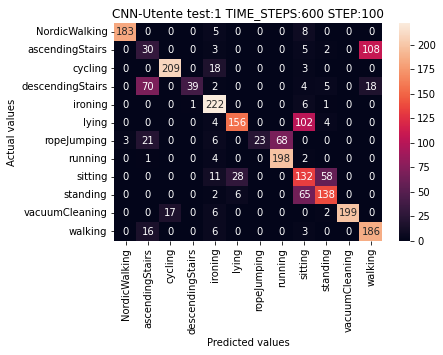

Utente test:  2
Training: x-> 12910 y-> 12910
Validation: x-> 3228 y-> 3228
Testing: x-> 2532 y-> 2532
Total: x-> 18670 y-> 18670
Epoch 1/100
101/101 [==============================] - 4s 37ms/step - loss: 1.7211 - accuracy: 0.4140 - f1_m: 0.2507 - val_loss: 1.0335 - val_accuracy: 0.6781 - val_f1_m: 0.5912
Epoch 2/100
101/101 [==============================] - 3s 32ms/step - loss: 1.0155 - accuracy: 0.6657 - f1_m: 0.6218 - val_loss: 0.7169 - val_accuracy: 0.7612 - val_f1_m: 0.7446
Epoch 3/100
101/101 [==============================] - 3s 32ms/step - loss: 0.7700 - accuracy: 0.7490 - f1_m: 0.7307 - val_loss: 0.6089 - val_accuracy: 0.7813 - val_f1_m: 0.7738
Epoch 4/100
101/101 [==============================] - 3s 31ms/step - loss: 0.6567 - accuracy: 0.7822 - f1_m: 0.7745 - val_loss: 0.5379 - val_accuracy: 0.8073 - val_f1_m: 0.8056
Epoch 5/100
101/101 [==============================] - 3s 31ms/step - loss: 0.5746 - accuracy: 0.8091 - f1_m: 0.8005 - val_loss: 0.5004 - val_accuracy: 0.8278

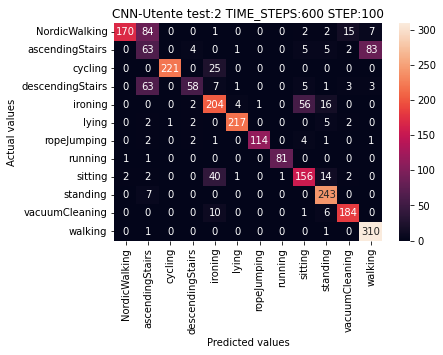

Utente test:  3
Training: x-> 13593 y-> 13593
Validation: x-> 3399 y-> 3399
Testing: x-> 1678 y-> 1678
Total: x-> 18670 y-> 18670
Epoch 1/100
107/107 [==============================] - 4s 36ms/step - loss: 1.4764 - accuracy: 0.4925 - f1_m: 0.3653 - val_loss: 0.8673 - val_accuracy: 0.7190 - val_f1_m: 0.6995
Epoch 2/100
107/107 [==============================] - 3s 32ms/step - loss: 0.8470 - accuracy: 0.7221 - f1_m: 0.7026 - val_loss: 0.6824 - val_accuracy: 0.7582 - val_f1_m: 0.7482
Epoch 3/100
107/107 [==============================] - 3s 32ms/step - loss: 0.6612 - accuracy: 0.7829 - f1_m: 0.7768 - val_loss: 0.5728 - val_accuracy: 0.8008 - val_f1_m: 0.7999
Epoch 4/100
107/107 [==============================] - 4s 33ms/step - loss: 0.5599 - accuracy: 0.8156 - f1_m: 0.8097 - val_loss: 0.4663 - val_accuracy: 0.8373 - val_f1_m: 0.8388
Epoch 5/100
107/107 [==============================] - 3s 32ms/step - loss: 0.5027 - accuracy: 0.8340 - f1_m: 0.8295 - val_loss: 0.4827 - val_accuracy: 0.8391

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


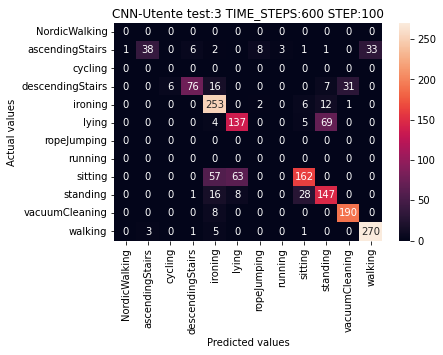

Utente test:  4
Training: x-> 13155 y-> 13155
Validation: x-> 3289 y-> 3289
Testing: x-> 2226 y-> 2226
Total: x-> 18670 y-> 18670
Epoch 1/100
103/103 [==============================] - 4s 38ms/step - loss: 1.5615 - accuracy: 0.4616 - f1_m: 0.3309 - val_loss: 1.0178 - val_accuracy: 0.6558 - val_f1_m: 0.6372
Epoch 2/100
103/103 [==============================] - 3s 33ms/step - loss: 0.9349 - accuracy: 0.6926 - f1_m: 0.6591 - val_loss: 0.7807 - val_accuracy: 0.7127 - val_f1_m: 0.7132
Epoch 3/100
103/103 [==============================] - 3s 33ms/step - loss: 0.6911 - accuracy: 0.7716 - f1_m: 0.7619 - val_loss: 0.6442 - val_accuracy: 0.7744 - val_f1_m: 0.7754
Epoch 4/100
103/103 [==============================] - 3s 32ms/step - loss: 0.5909 - accuracy: 0.8052 - f1_m: 0.7990 - val_loss: 0.6088 - val_accuracy: 0.7863 - val_f1_m: 0.7840
Epoch 5/100
103/103 [==============================] - 3s 33ms/step - loss: 0.5368 - accuracy: 0.8174 - f1_m: 0.8130 - val_loss: 0.5100 - val_accuracy: 0.8136

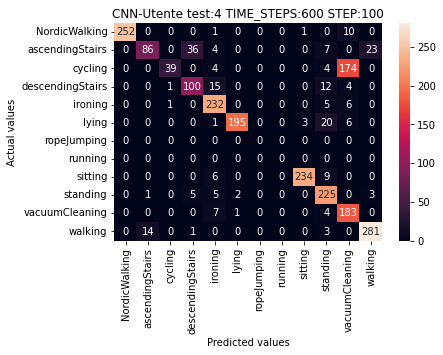

Utente test:  5
Training: x-> 12830 y-> 12830
Validation: x-> 3208 y-> 3208
Testing: x-> 2632 y-> 2632
Total: x-> 18670 y-> 18670
Epoch 1/100
101/101 [==============================] - 4s 36ms/step - loss: 1.5797 - accuracy: 0.4513 - f1_m: 0.3013 - val_loss: 0.9705 - val_accuracy: 0.6680 - val_f1_m: 0.6027
Epoch 2/100
101/101 [==============================] - 3s 32ms/step - loss: 0.8865 - accuracy: 0.7109 - f1_m: 0.6850 - val_loss: 0.5942 - val_accuracy: 0.8173 - val_f1_m: 0.8071
Epoch 3/100
101/101 [==============================] - 3s 32ms/step - loss: 0.6259 - accuracy: 0.7999 - f1_m: 0.7936 - val_loss: 0.5703 - val_accuracy: 0.8130 - val_f1_m: 0.8159
Epoch 4/100
101/101 [==============================] - 3s 33ms/step - loss: 0.5439 - accuracy: 0.8243 - f1_m: 0.8243 - val_loss: 0.4455 - val_accuracy: 0.8538 - val_f1_m: 0.8646
Epoch 5/100
101/101 [==============================] - 3s 32ms/step - loss: 0.4725 - accuracy: 0.8485 - f1_m: 0.8451 - val_loss: 0.4176 - val_accuracy: 0.8594

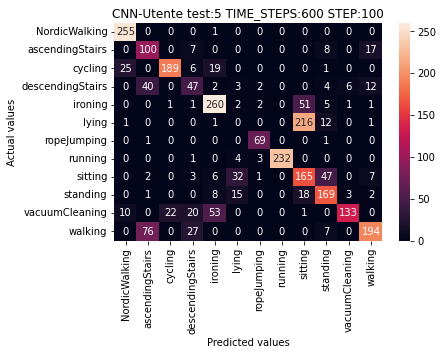

Utente test:  6
Training: x-> 13001 y-> 13001
Validation: x-> 3251 y-> 3251
Testing: x-> 2418 y-> 2418
Total: x-> 18670 y-> 18670
Epoch 1/100
102/102 [==============================] - 4s 38ms/step - loss: 1.5823 - accuracy: 0.4495 - f1_m: 0.3151 - val_loss: 1.0930 - val_accuracy: 0.6312 - val_f1_m: 0.5240
Epoch 2/100
102/102 [==============================] - 3s 33ms/step - loss: 0.9368 - accuracy: 0.6914 - f1_m: 0.6596 - val_loss: 0.8288 - val_accuracy: 0.7072 - val_f1_m: 0.6875
Epoch 3/100
102/102 [==============================] - 3s 33ms/step - loss: 0.6674 - accuracy: 0.7818 - f1_m: 0.7723 - val_loss: 0.5847 - val_accuracy: 0.8010 - val_f1_m: 0.7961
Epoch 4/100
102/102 [==============================] - 3s 33ms/step - loss: 0.5884 - accuracy: 0.8053 - f1_m: 0.8003 - val_loss: 0.6087 - val_accuracy: 0.7859 - val_f1_m: 0.7907
Epoch 5/100
102/102 [==============================] - 3s 32ms/step - loss: 0.5030 - accuracy: 0.8280 - f1_m: 0.8275 - val_loss: 0.4828 - val_accuracy: 0.8324

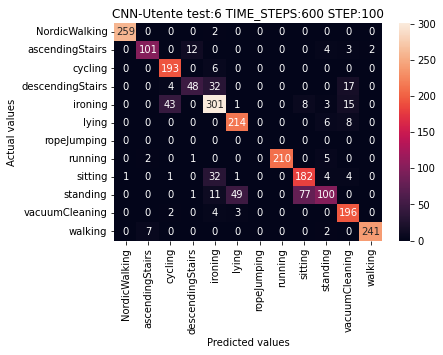

Utente test:  7
Training: x-> 13142 y-> 13142
Validation: x-> 3286 y-> 3286
Testing: x-> 2242 y-> 2242
Total: x-> 18670 y-> 18670
Epoch 1/100
103/103 [==============================] - 4s 37ms/step - loss: 1.7060 - accuracy: 0.4079 - f1_m: 0.2657 - val_loss: 1.0224 - val_accuracy: 0.6695 - val_f1_m: 0.5943
Epoch 2/100
103/103 [==============================] - 3s 34ms/step - loss: 0.9863 - accuracy: 0.6733 - f1_m: 0.6293 - val_loss: 0.7798 - val_accuracy: 0.7234 - val_f1_m: 0.7079
Epoch 3/100
103/103 [==============================] - 3s 33ms/step - loss: 0.7648 - accuracy: 0.7471 - f1_m: 0.7289 - val_loss: 0.6968 - val_accuracy: 0.7687 - val_f1_m: 0.7537
Epoch 4/100
103/103 [==============================] - 3s 34ms/step - loss: 0.6448 - accuracy: 0.7869 - f1_m: 0.7807 - val_loss: 0.4985 - val_accuracy: 0.8348 - val_f1_m: 0.8368
Epoch 5/100
103/103 [==============================] - 3s 33ms/step - loss: 0.5461 - accuracy: 0.8207 - f1_m: 0.8170 - val_loss: 0.4583 - val_accuracy: 0.8475

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


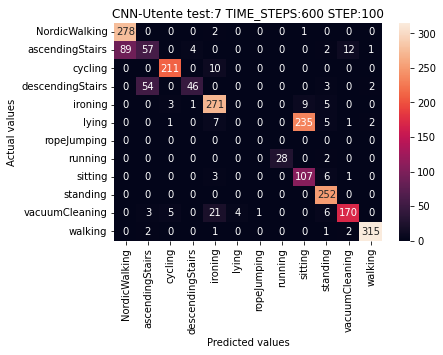

Utente test:  8
Training: x-> 12909 y-> 12909
Validation: x-> 3228 y-> 3228
Testing: x-> 2533 y-> 2533
Total: x-> 18670 y-> 18670
Epoch 1/100
101/101 [==============================] - 4s 39ms/step - loss: 1.4521 - accuracy: 0.5060 - f1_m: 0.3813 - val_loss: 1.0165 - val_accuracy: 0.6577 - val_f1_m: 0.6294
Epoch 2/100
101/101 [==============================] - 3s 32ms/step - loss: 0.8467 - accuracy: 0.7143 - f1_m: 0.6947 - val_loss: 0.7124 - val_accuracy: 0.7751 - val_f1_m: 0.7621
Epoch 3/100
101/101 [==============================] - 3s 34ms/step - loss: 0.6448 - accuracy: 0.7873 - f1_m: 0.7792 - val_loss: 0.5699 - val_accuracy: 0.8216 - val_f1_m: 0.8186
Epoch 4/100
101/101 [==============================] - 3s 33ms/step - loss: 0.5393 - accuracy: 0.8252 - f1_m: 0.8210 - val_loss: 0.5224 - val_accuracy: 0.8296 - val_f1_m: 0.8292
Epoch 5/100
101/101 [==============================] - 3s 33ms/step - loss: 0.4646 - accuracy: 0.8492 - f1_m: 0.8460 - val_loss: 0.4594 - val_accuracy: 0.8529

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


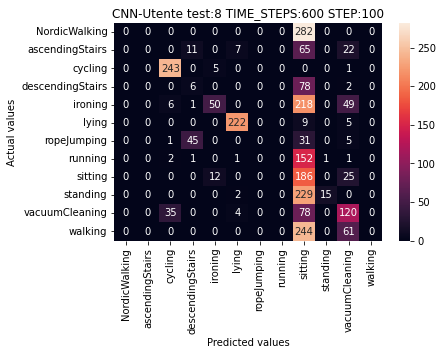

Accuracy media: 0.716292214828348
F1 weighted media: 0.6994698520535185
F1 macro media: 0.6426310195956269
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.716292              0.69947          0.642631   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

            model = createCNN(X_train[0].shape, y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            print("Training: x->",len(XTraining),"y->",len(YTraining))
            print("Validation: x->",len(XValidation),"y->",len(YValidation))
            print("Testing: x->",len(X_test),"y->",len(y_test))
            print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            cnn_acc.append(accuracy_score(rounded_labels, y_pred))
            cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            cnn_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

            cnn_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


# Bi-LSTM

In [ ]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [ ]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [ ]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1
Epoch 1/100
102/102 [==============================] - 21s 118ms/step - loss: 1.7522 - accuracy: 0.4154 - val_loss: 1.3093 - val_accuracy: 0.5626
Epoch 2/100
102/102 [==============================] - 11s 106ms/step - loss: 1.4039 - accuracy: 0.5179 - val_loss: 1.1530 - val_accuracy: 0.5921
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 1.2346 - accuracy: 0.5802 - val_loss: 0.9824 - val_accuracy: 0.6852
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 1.2099 - accuracy: 0.5949 - val_loss: 1.0877 - val_accuracy: 0.5985
Epoch 5/100
102/102 [==============================] - 11s 107ms/step - loss: 1.1171 - accuracy: 0.6312 - val_loss: 0.9288 - val_accuracy: 0.6975
Epoch 6/100
102/102 [==============================] - 11s 106ms/step - loss: 1.0887 - accuracy: 0.6386 - val_loss: 0.9936 - val_accuracy: 0.6471
Epoch 7/100
102/102 [==============================] - 11s 107ms/step - loss: 0.9733 - accuracy: 0.6

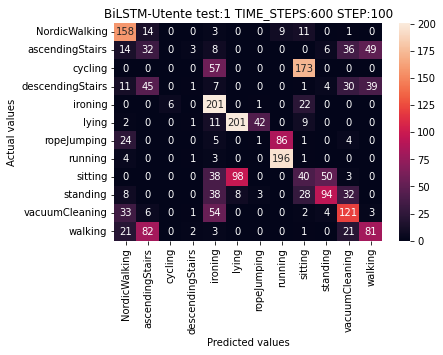

Utente test:  2
Epoch 1/100
101/101 [==============================] - 19s 123ms/step - loss: 1.7571 - accuracy: 0.3974 - val_loss: 1.2922 - val_accuracy: 0.5589
Epoch 2/100
101/101 [==============================] - 11s 108ms/step - loss: 1.3893 - accuracy: 0.5238 - val_loss: 1.2037 - val_accuracy: 0.5874
Epoch 3/100
101/101 [==============================] - 11s 110ms/step - loss: 1.3010 - accuracy: 0.5637 - val_loss: 1.1607 - val_accuracy: 0.5877
Epoch 4/100
101/101 [==============================] - 11s 107ms/step - loss: 1.2688 - accuracy: 0.5614 - val_loss: 1.1103 - val_accuracy: 0.6221
Epoch 5/100
101/101 [==============================] - 11s 106ms/step - loss: 1.1787 - accuracy: 0.6036 - val_loss: 1.0353 - val_accuracy: 0.6552
Epoch 6/100
101/101 [==============================] - 11s 109ms/step - loss: 1.1887 - accuracy: 0.6052 - val_loss: 1.1827 - val_accuracy: 0.5874
Epoch 7/100
101/101 [==============================] - 11s 108ms/step - loss: 1.1814 - accuracy: 0.5963 - va

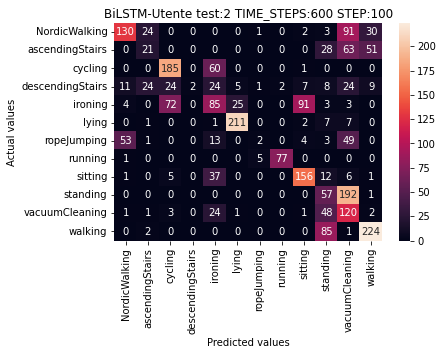

Utente test:  3
Epoch 1/100
107/107 [==============================] - 20s 132ms/step - loss: 1.7739 - accuracy: 0.3983 - val_loss: 1.2728 - val_accuracy: 0.5746
Epoch 2/100
107/107 [==============================] - 12s 109ms/step - loss: 1.3282 - accuracy: 0.5404 - val_loss: 1.0725 - val_accuracy: 0.6499
Epoch 3/100
107/107 [==============================] - 12s 108ms/step - loss: 1.2984 - accuracy: 0.5623 - val_loss: 1.0940 - val_accuracy: 0.5975
Epoch 4/100
107/107 [==============================] - 12s 109ms/step - loss: 1.2908 - accuracy: 0.5509 - val_loss: 1.0607 - val_accuracy: 0.6467
Epoch 5/100
107/107 [==============================] - 12s 111ms/step - loss: 1.1851 - accuracy: 0.6002 - val_loss: 1.1121 - val_accuracy: 0.6355
Epoch 6/100
107/107 [==============================] - 12s 108ms/step - loss: 1.1907 - accuracy: 0.5968 - val_loss: 1.0250 - val_accuracy: 0.6308
Epoch 7/100
107/107 [==============================] - 12s 108ms/step - loss: 1.0934 - accuracy: 0.6365 - va

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


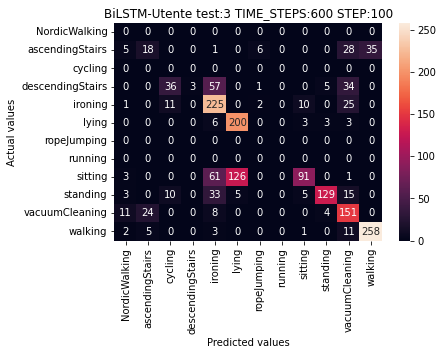

Utente test:  4
Epoch 1/100
103/103 [==============================] - 18s 122ms/step - loss: 1.7877 - accuracy: 0.3870 - val_loss: 1.3542 - val_accuracy: 0.5421
Epoch 2/100
103/103 [==============================] - 11s 109ms/step - loss: 1.4552 - accuracy: 0.5006 - val_loss: 1.1969 - val_accuracy: 0.6032
Epoch 3/100
103/103 [==============================] - 11s 109ms/step - loss: 1.2768 - accuracy: 0.5764 - val_loss: 1.1218 - val_accuracy: 0.6236
Epoch 4/100
103/103 [==============================] - 13s 124ms/step - loss: 1.1098 - accuracy: 0.6404 - val_loss: 0.9396 - val_accuracy: 0.6865
Epoch 5/100
103/103 [==============================] - 11s 110ms/step - loss: 1.0543 - accuracy: 0.6547 - val_loss: 0.9246 - val_accuracy: 0.6902
Epoch 6/100
103/103 [==============================] - 11s 109ms/step - loss: 1.0708 - accuracy: 0.6533 - val_loss: 1.2089 - val_accuracy: 0.5889
Epoch 7/100
103/103 [==============================] - 11s 110ms/step - loss: 1.1878 - accuracy: 0.6020 - va

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


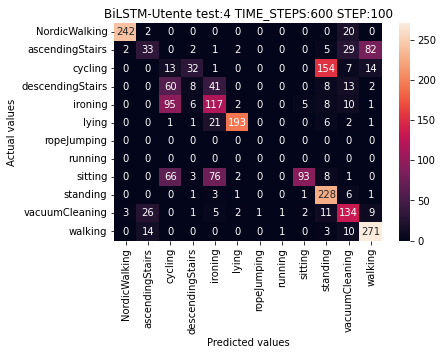

Utente test:  5
Epoch 1/100
101/101 [==============================] - 18s 122ms/step - loss: 1.7369 - accuracy: 0.4235 - val_loss: 1.3599 - val_accuracy: 0.5742
Epoch 2/100
101/101 [==============================] - 12s 122ms/step - loss: 1.3956 - accuracy: 0.5522 - val_loss: 1.2491 - val_accuracy: 0.5689
Epoch 3/100
101/101 [==============================] - 11s 110ms/step - loss: 1.2540 - accuracy: 0.5869 - val_loss: 1.0293 - val_accuracy: 0.6674
Epoch 4/100
101/101 [==============================] - 11s 111ms/step - loss: 1.1692 - accuracy: 0.6228 - val_loss: 0.9770 - val_accuracy: 0.6945
Epoch 5/100
101/101 [==============================] - 11s 110ms/step - loss: 1.0588 - accuracy: 0.6582 - val_loss: 0.8568 - val_accuracy: 0.7142
Epoch 6/100
101/101 [==============================] - 11s 110ms/step - loss: 1.1586 - accuracy: 0.6288 - val_loss: 0.9484 - val_accuracy: 0.6746
Epoch 7/100
101/101 [==============================] - 11s 111ms/step - loss: 1.0227 - accuracy: 0.6693 - va

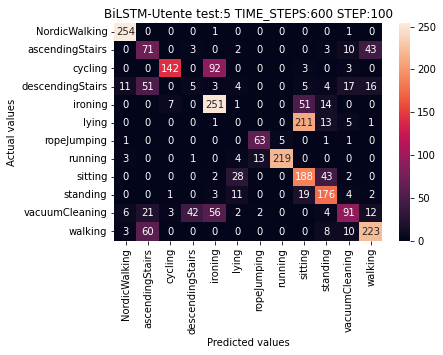

Utente test:  6
Epoch 1/100
102/102 [==============================] - 18s 124ms/step - loss: 1.8295 - accuracy: 0.3687 - val_loss: 1.3791 - val_accuracy: 0.5211
Epoch 2/100
102/102 [==============================] - 11s 111ms/step - loss: 1.4526 - accuracy: 0.5125 - val_loss: 1.0859 - val_accuracy: 0.6518
Epoch 3/100
102/102 [==============================] - 11s 110ms/step - loss: 1.3553 - accuracy: 0.5414 - val_loss: 1.0764 - val_accuracy: 0.6124
Epoch 4/100
102/102 [==============================] - 11s 112ms/step - loss: 1.3186 - accuracy: 0.5500 - val_loss: 1.1298 - val_accuracy: 0.5887
Epoch 5/100
102/102 [==============================] - 11s 109ms/step - loss: 1.1998 - accuracy: 0.5992 - val_loss: 0.9608 - val_accuracy: 0.6801
Epoch 6/100
102/102 [==============================] - 11s 109ms/step - loss: 1.1663 - accuracy: 0.6191 - val_loss: 1.0592 - val_accuracy: 0.6506
Epoch 7/100
102/102 [==============================] - 11s 110ms/step - loss: 1.2621 - accuracy: 0.5894 - va

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9444    0.9770    0.9605       261
           1     0.2500    0.0492    0.0822       122
           2     0.3733    0.9548    0.5367       199
           3     0.4286    0.0297    0.0556       101
           4     0.6413    0.4771    0.5471       371
           5     0.7200    0.9474    0.8182       228
           6     0.0000    0.0000    0.0000         0
           7     0.9952    0.9450    0.9694       218
           8     0.8878    0.7733    0.8266       225
           9     0.1168    0.0966    0.1057       238
          10     0.5597    0.4341    0.4890       205
          11     0.6765    0.7360    0.7050       250

    accuracy                         0.6299      2418
   macro avg     0.5495    0.5350    0.5080      2418
weighted avg     0.6307    0.6299    0.6045      2418



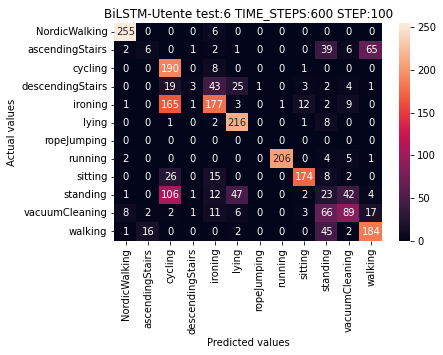

Utente test:  7
Epoch 1/100
103/103 [==============================] - 18s 125ms/step - loss: 1.8559 - accuracy: 0.3796 - val_loss: 1.3278 - val_accuracy: 0.5548
Epoch 2/100
103/103 [==============================] - 12s 113ms/step - loss: 1.3675 - accuracy: 0.5454 - val_loss: 1.1400 - val_accuracy: 0.6147
Epoch 3/100
103/103 [==============================] - 12s 112ms/step - loss: 1.2314 - accuracy: 0.5891 - val_loss: 0.9992 - val_accuracy: 0.6564
Epoch 4/100
103/103 [==============================] - 12s 113ms/step - loss: 1.0799 - accuracy: 0.6413 - val_loss: 0.9754 - val_accuracy: 0.6637
Epoch 5/100
103/103 [==============================] - 12s 112ms/step - loss: 1.1253 - accuracy: 0.6233 - val_loss: 0.9307 - val_accuracy: 0.6869
Epoch 6/100
103/103 [==============================] - 11s 111ms/step - loss: 1.0860 - accuracy: 0.6343 - val_loss: 0.9439 - val_accuracy: 0.6759
Epoch 7/100
103/103 [==============================] - 12s 113ms/step - loss: 0.9972 - accuracy: 0.6637 - va

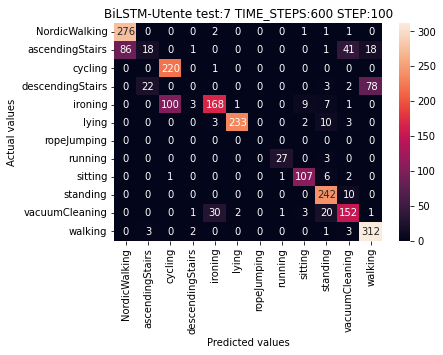

Utente test:  8
Epoch 1/100
101/101 [==============================] - 18s 123ms/step - loss: 1.7836 - accuracy: 0.3956 - val_loss: 1.3126 - val_accuracy: 0.5397
Epoch 2/100
101/101 [==============================] - 11s 111ms/step - loss: 1.3143 - accuracy: 0.5469 - val_loss: 1.1163 - val_accuracy: 0.6047
Epoch 3/100
101/101 [==============================] - 11s 111ms/step - loss: 1.2295 - accuracy: 0.5858 - val_loss: 1.0159 - val_accuracy: 0.6695
Epoch 4/100
101/101 [==============================] - 11s 110ms/step - loss: 1.0931 - accuracy: 0.6389 - val_loss: 1.0387 - val_accuracy: 0.6496
Epoch 5/100
101/101 [==============================] - 11s 112ms/step - loss: 1.1985 - accuracy: 0.6048 - val_loss: 0.9140 - val_accuracy: 0.6846
Epoch 6/100
101/101 [==============================] - 11s 111ms/step - loss: 1.0739 - accuracy: 0.6510 - val_loss: 0.9068 - val_accuracy: 0.6874
Epoch 7/100
101/101 [==============================] - 11s 112ms/step - loss: 1.1117 - accuracy: 0.6289 - va

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       282
           1     1.0000    0.0762    0.1416       105
           2     0.7405    0.9398    0.8283       249
           3     0.0000    0.0000    0.0000        86
           4     0.4667    0.0216    0.0413       324
           5     0.6862    0.9449    0.7950       236
           6     0.0000    0.0000    0.0000        82
           7     0.0000    0.0000    0.0000       158
           8     0.3615    0.8251    0.5027       223
           9     0.9400    0.1911    0.3176       246
          10     0.1664    0.8481    0.2782       237
          11     0.0000    0.0000    0.0000       305

    accuracy                         0.3569      2533
   macro avg     0.3634    0.3206    0.2421      2533
weighted avg     0.3766    0.3569    0.2678      2533



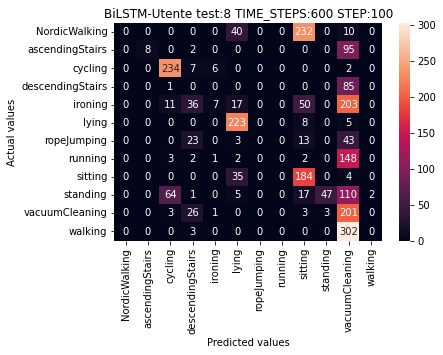

Accuracy media: 0.5771236734620079
F1 media macro: 0.46802832316002335
F1 media weighted: 0.46802832316002335


In [ ]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if id != user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

            model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
            bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            bilstm_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

            bilstm_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [ ]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

,Time Steps,Step,Average accuracy,Average F1 weighted,Average F1 macro,reports,confusion_matrix
0,600,100,0.577124,0.540343,0.468028,[ precision recall f1-score ...,"[AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp..."


# SHALLOW LEARNING

## Random Forest

In [ ]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       0.49      0.91      0.64       196
 ascendingStairs       0.35      0.85      0.50       148
         cycling       0.95      0.42      0.58       230
descendingStairs       0.00      0.00      0.00       138
         ironing       0.48      0.99      0.64       230
           lying       0.85      0.72      0.78       266
     ropeJumping       0.00      0.00      0.00       121
         running       1.00      0.95      0.97       205
         sitting       0.58      0.46      0.51       229
        standing       0.71      0.65      0.68       211
  vacuumCleaning       0.88      0.75      0.81       224
         walking       0.74      0.27      0.40       211

        accuracy                           0.62      2409
       macro avg       0.59      0.58      0.54      2409
    weighted avg       0.64      0.62      0.59      2409

f1:  0.586986993765953
acc:  0.6151930261519303


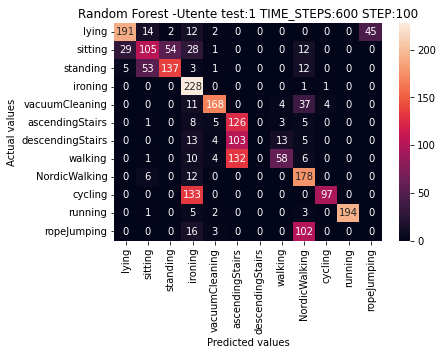

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       0.46      0.37      0.41       281
 ascendingStairs       0.52      0.40      0.45       163
         cycling       0.83      0.67      0.74       246
descendingStairs       0.00      0.00      0.00       141
         ironing       0.59      0.93      0.72       283
           lying       1.00      0.94      0.97       229
     ropeJumping       0.00      0.00      0.00       125
         running       1.00      0.98      0.99        83
         sitting       0.85      0.69      0.76       218
        standing       0.90      0.97      0.93       250
  vacuumCleaning       0.52      0.81      0.63       201
         walking       0.66      1.00      0.79       312

        accuracy                           0.70      2532
       macro avg       0.61      0.65      0.62      2532
    weighted avg       0.64      0.70      0.65      2532

f1:  0.6522435765967558
acc:  0.6951026856240127


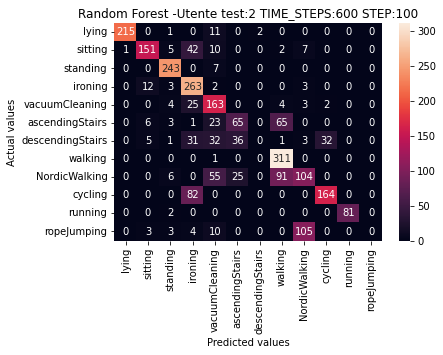

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       0.00      0.00      0.00         0
 ascendingStairs       0.96      0.27      0.42        93
         cycling       0.00      0.00      0.00         0
descendingStairs       0.00      0.00      0.00       136
         ironing       0.53      0.74      0.62       274
           lying       0.85      0.64      0.73       215
         sitting       0.66      0.49      0.57       282
        standing       0.93      0.71      0.81       200
  vacuumCleaning       0.61      0.91      0.73       198
         walking       0.90      0.93      0.92       280

        accuracy                           0.65      1678
       macro avg       0.54      0.47      0.48      1678
    weighted avg       0.69      0.65      0.65      1678

f1:  0.6484808710590363
acc:  0.6495828367103695


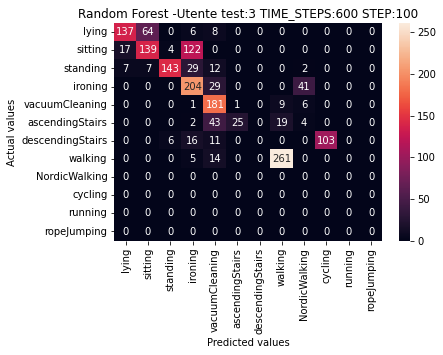

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_

                  precision    recall  f1-score   support

   NordicWalking       0.98      0.66      0.79       264
 ascendingStairs       0.90      0.51      0.65       156
         cycling       0.08      0.07      0.07       221
descendingStairs       0.71      0.04      0.07       132
         ironing       0.38      0.63      0.47       244
           lying       1.00      0.86      0.93       225
     ropeJumping       0.00      0.00      0.00         0
         sitting       0.51      0.09      0.16       249
        standing       0.85      0.94      0.90       241
  vacuumCleaning       0.35      0.89      0.50       195
         walking       0.80      0.94      0.87       299

        accuracy                           0.60      2226
       macro avg       0.60      0.51      0.49      2226
    weighted avg       0.66      0.60      0.57      2226

f1:  0.5703602490272077
acc:  0.5952380952380952


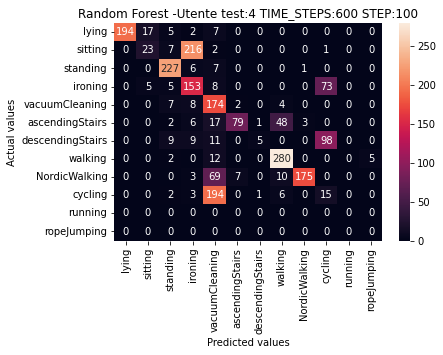

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished


                  precision    recall  f1-score   support

   NordicWalking       0.82      0.99      0.90       256
 ascendingStairs       0.55      0.44      0.49       132
         cycling       0.88      0.67      0.76       240
descendingStairs       0.80      0.03      0.07       116
         ironing       0.56      0.82      0.66       324
           lying       0.00      0.00      0.00       231
     ropeJumping       0.95      0.85      0.90        71
         running       1.00      0.94      0.97       240
         sitting       0.44      0.70      0.54       263
        standing       0.57      0.76      0.65       216
  vacuumCleaning       0.66      0.48      0.56       239
         walking       0.72      0.86      0.78       304

        accuracy                           0.67      2632
       macro avg       0.66      0.63      0.61      2632
    weighted avg       0.64      0.67      0.63      2632

f1:  0.6265964540592729
acc:  0.665273556231003


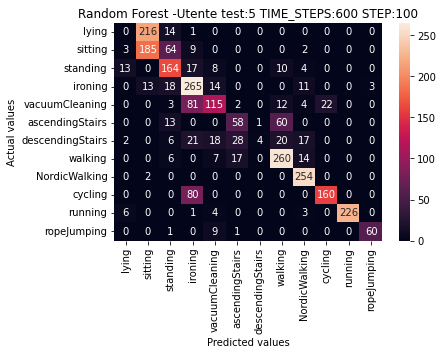

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished


                  precision    recall  f1-score   support

   NordicWalking       0.93      1.00      0.96       261
 ascendingStairs       0.93      0.79      0.85       122
         cycling       0.60      0.98      0.74       199
descendingStairs       0.00      0.00      0.00       101
         ironing       0.62      0.59      0.60       371
           lying       0.80      0.95      0.87       228
         running       1.00      0.95      0.98       218
         sitting       0.80      0.79      0.79       225
        standing       0.87      0.50      0.63       238
  vacuumCleaning       0.67      0.85      0.75       205
         walking       0.94      0.98      0.96       250

        accuracy                           0.79      2418
       macro avg       0.74      0.76      0.74      2418
    weighted avg       0.77      0.79      0.77      2418

f1:  0.7697663859832736
acc:  0.7894954507857733


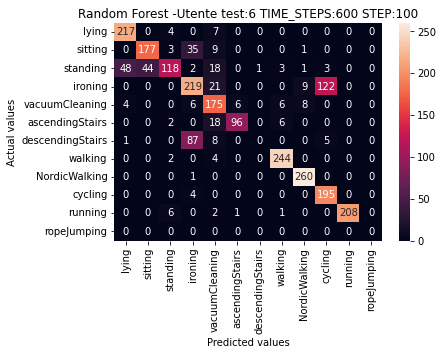

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished


                  precision    recall  f1-score   support

   NordicWalking       0.75      0.95      0.84       281
 ascendingStairs       0.39      0.19      0.25       165
         cycling       0.94      0.99      0.96       221
descendingStairs       0.00      0.00      0.00       105
         ironing       0.87      0.91      0.89       289
           lying       0.99      0.82      0.89       251
         running       1.00      0.87      0.93        30
         sitting       0.76      0.92      0.83       117
        standing       0.90      0.96      0.93       252
  vacuumCleaning       0.72      0.83      0.77       210
         walking       0.81      0.97      0.88       321

        accuracy                           0.82      2242
       macro avg       0.74      0.76      0.74      2242
    weighted avg       0.78      0.82      0.79      2242

f1:  0.7924236403248371
acc:  0.8233719892952721


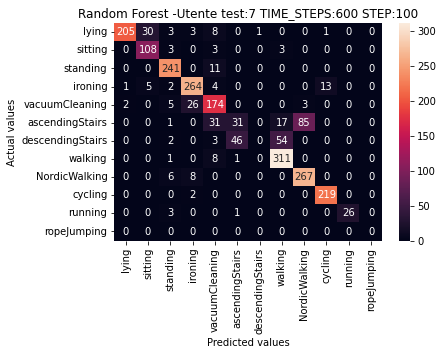

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.7s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       1.00      0.00      0.01       282
 ascendingStairs       0.84      0.20      0.32       105
         cycling       0.40      1.00      0.57       249
descendingStairs       0.02      0.02      0.02        86
         ironing       0.79      0.43      0.56       324
           lying       0.71      0.96      0.82       236
     ropeJumping       0.00      0.00      0.00        82
         running       1.00      0.91      0.95       158
         sitting       0.27      0.51      0.35       223
        standing       0.98      0.22      0.36       246
  vacuumCleaning       0.57      0.39      0.47       237
         walking       0.60      0.94      0.73       305

        accuracy                           0.53      2533
       macro avg       0.60      0.47      0.43      2533
    weighted avg       0.66      0.53      0.48      2533

f1:  0.4764435728141551
acc:  0.5266482431898935


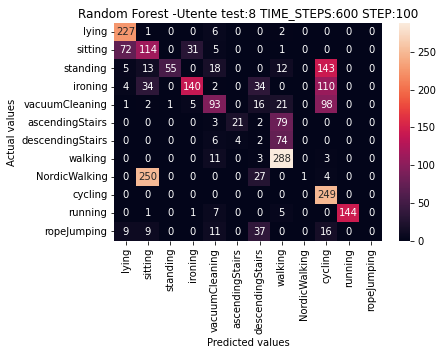

F1 total:  0.6404127179538114
Accuracy total:  0.6699882354032938
   Time Steps  Step  Average accuracy  Average F1
0         600   100          0.669988    0.640413


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [ ]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

   NordicWalking       0.36      0.55      0.44       196
 ascendingStairs       0.44      0.89      0.59       148
         cycling       0.82      0.06      0.11       230
descendingStairs       0.25      0.18      0.21       138
         ironing       0.31      0.61      0.41       230
           lying       0.85      0.98      0.91       266
     ropeJumping       0.00      0.00      0.00       121
         running       0.74      0.97      0.84       205
         sitting       0.56      0.90      0.69       229
        standing       0.36      0.17      0.23       211
  vacuumCleaning       0.76      0.32      0.45       224
         walking       0.96      0.54      0.69       211

        accuracy                           0.54      2409
       macro avg       0.54      0.51      0.46      2409
    weighted avg       0.58      0.54      0.49      2409

f1 macro:  0.46448212825785823
f1 weighted:  0.49417965705278544
acc:

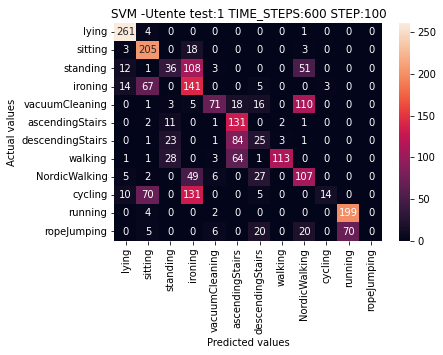

[LibSVM]

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [ ]:
svm_results_df

In [ ]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))